In [1]:
!gpustat 

gpuserver4  Sun May 26 14:14:47 2019
[0] GeForce GTX 1080 Ti | 57'C,  20 % | 11171 / 11178 MB | chenshouyu(11161M)
[1] GeForce GTX 1080 Ti | 61'C,  15 % | 11171 / 11178 MB | chenshouyu(11161M)
[2] GeForce GTX 1080 Ti | 72'C,   0 % | 10611 / 11178 MB | chenshouyu(10601M)
[3] GeForce GTX 1080 Ti | 34'C,   0 % |  1193 / 11178 MB | zbc(1183M)
[4] GeForce GTX 1080 Ti | 36'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 35'C,   0 % |  1253 / 11178 MB | zbc(1243M)
[6] GeForce GTX 1080 Ti | 71'C,  16 % | 11171 / 11178 MB | chenshouyu(11161M)
[7] GeForce GTX 1080 Ti | 65'C,  29 % | 11171 / 11178 MB | chenshouyu(11161M)
[8] GeForce GTX 1080 Ti | 65'C,   0 % | 10611 / 11178 MB | chenshouyu(10601M)
[9] GeForce GTX 1080 Ti | 37'C,   0 % |    10 / 11178 MB |


In [2]:
%env CUDA_VISIBLE_DEVICES=9

env: CUDA_VISIBLE_DEVICES=9


In [3]:
'''
    We are going to use PyTorch to implement our model, since
    PyTorch has autograd(which can automaticly calculate the 
    gradient for us), we don't need to calculate the gradient
    manually
    
    torch is the main library used
    numpy support basic matrix calculation
    torchvision is a helper function library
'''

import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [4]:
'''
    First define a transform which transform a numpy array(cifar10 image
    is represented as numpy array) to PyTorch Tensor, and Normalize it
    by mean (.5, .5, .5) and std (.5, .5, .5)
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

'''
    torchvision can help us get the CIFAR10 data and split it to 
    train and test
'''
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


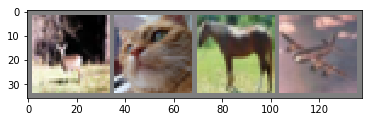

 deer   cat horse plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
    '''
        inherit the nn.Module to get the autograd working
        useing the torch.nn interface, we can build a linear
        model with autograd
    '''
    def __init__(self):
        super(linear_model, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10, bias=True) # bias = True to represent f(x;W)=Wx+b
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        return self.linear(x)
model = linear_model().cuda()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss is not MSE..., but it can perform better
# than MSE, you get the idea~, just don't care too much

# we can implement SGD in one line in PyTorch
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # from the train set, get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.157
[1,  4000] loss: 2.153
[1,  6000] loss: 2.146
[1,  8000] loss: 2.116
[1, 10000] loss: 2.141
[1, 12000] loss: 2.180
[2,  2000] loss: 2.069
[2,  4000] loss: 2.098
[2,  6000] loss: 2.111
[2,  8000] loss: 2.086
[2, 10000] loss: 2.098
[2, 12000] loss: 2.138
Finished Training


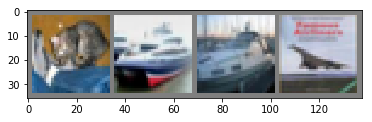

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat truck  ship  ship


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 33 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 27 %
Accuracy of   car : 34 %
Accuracy of  bird : 14 %
Accuracy of   cat : 40 %
Accuracy of  deer : 25 %
Accuracy of   dog : 27 %
Accuracy of  frog : 23 %
Accuracy of horse : 35 %
Accuracy of  ship : 60 %
Accuracy of truck : 42 %


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().cuda()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.254
[1,  4000] loss: 1.966
[1,  6000] loss: 1.818
[1,  8000] loss: 1.698
[1, 10000] loss: 1.632
[1, 12000] loss: 1.578
[2,  2000] loss: 1.506
[2,  4000] loss: 1.500
[2,  6000] loss: 1.461
[2,  8000] loss: 1.447
[2, 10000] loss: 1.413
[2, 12000] loss: 1.396
Finished Training


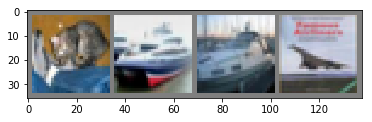

GroundTruth:    cat  ship  ship plane


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship plane


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 67 %
Accuracy of  bird : 24 %
Accuracy of   cat : 14 %
Accuracy of  deer : 52 %
Accuracy of   dog : 41 %
Accuracy of  frog : 63 %
Accuracy of horse : 60 %
Accuracy of  ship : 45 %
Accuracy of truck : 51 %
